<a href="https://colab.research.google.com/github/Vahid-GitHub/Optimization/blob/master/03_optimization_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# How does optimization work on PyTorch?

In [2]:
# libraries
import torch
import matplotlib.pyplot as plt

In [3]:
# device configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


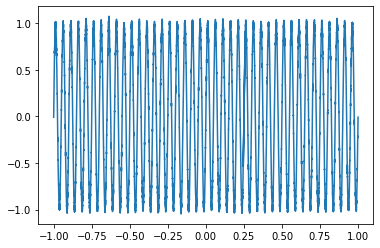

In [4]:
# making the function
pi = torch.acos(torch.Tensor([-1])).to(device)
ns = 10000
freq = 20
mu, std = 0, 0.02
data_type = torch.float32
t = torch.linspace(-1, 1, ns, dtype=data_type, device=device).reshape((ns, 1))
fun1 = torch.sin(2*pi*freq*t).to(device) + torch.randn((ns, 1), device=device) * std + mu
plt.plot(t.cpu(), fun1.cpu())

MSE:  0.49127426743507385


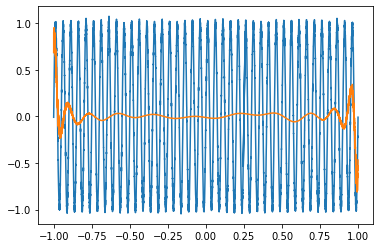

In [5]:
# # add bias
# t_bias = torch.cat((torch.ones((t.shape[0], 1), device=device), t), dim=1)
# print(t_bias[:10, :])
# # add bias and sin
# t_extended = torch.cat((torch.ones((t.shape[0], 1), device=device), t, torch.sin(2*pi*0.5*t)), dim=1)

# # add bias and x^2
# t_extended = torch.cat((torch.ones((t.shape[0], 1), device=device), t, t**2), dim=1)

# add bias and higher orders polynomials
t_extended = torch.ones((t.shape[0], 1), device=device)
for order in range(1, 30, 1):
    t_extended = torch.cat((t_extended, t**order), dim=1)

# # add bias and higher orders geometrical functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 45):
#     t_extended = torch.cat((t_extended, torch.sin(order*t), torch.cos(order*t)), dim=1)

# # add bias and higher orders tanh functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 20, 3):
#     t_extended = torch.cat((t_extended, torch.tanh(order*t)), dim=1)

# # add bias and higher orders sigmoid functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 20):
#     t_extended = torch.cat((t_extended, torch.sigmoid(order*t)), dim=1)

# # add bias and higher orders functions
# t_extended = torch.ones((t.shape[0], 1), device=device, dtype=data_type)
# t_extended = torch.cat((t_extended, t), dim=1)
# for order in range(1, 50, 5):
#     t_extended = torch.cat((t_extended, torch.nn.functional.softsign(order*t)), dim=1)


# optimize with lstsq
X, QR = torch.lstsq(fun1, t_extended)
# just the first 2 elements of the output is the answer and all others are residuals.
line = t_extended.mm(X[0:t_extended.shape[1]])
print('MSE: ', torch.nn.functional.mse_loss(line, fun1).item())
plt.figure()
plt.plot(t.cpu(), fun1.cpu())
plt.plot(t.cpu(), line.cpu())

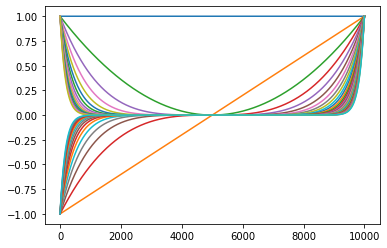

In [6]:
plt.figure()
for order in range(t_extended.shape[1]):
    plt.plot(t_extended[:, order].cpu())

In [7]:
# estimation function
def est_func(x, a):
    y = x**a
    # y = torch.tanh(a*x)
    # y = torch.sigmoid(x/a)
    # y = torch.sin(a*x)
    return(y)

MSE: 0.0665 with 400 parameters.


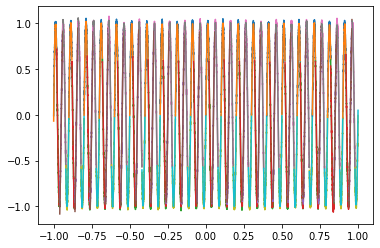

In [8]:
# piecewise estimation
degree = 4
piece_len = 100
mse = 0
Xs = torch.Tensor([]).reshape((degree, 0)).to(device)
dataset = torch.cat((t, fun1), dim=1)
dloader = torch.utils.data.DataLoader(dataset, batch_size=piece_len)
for tfun in dloader:
    params, fun = tfun[:, :-1], tfun[:, -1:]
    # piece-wise plot
    plt.plot(params.cpu(), fun.cpu())
    # piece-wise estimation
    # add bias and higher orders polynomials
    params_extended = torch.ones((params.shape[0], 1), device=device)
    for order in range(1, degree, 1):
        params_extended = torch.cat((params_extended, est_func(params, order)), dim=1)
    X, QR = torch.lstsq(fun, params_extended)
    coeff = X[0:degree]
    Xs = torch.cat((Xs, coeff), dim=1)
    line = params_extended.mm(coeff)
    mse += torch.nn.functional.mse_loss(line, fun).item()
    plt.plot(params.cpu(), line.cpu())
print(f'MSE: {mse:.4f} with {Xs.size().numel()} parameters.')